In [1]:
from pathlib import Path
import dask
import xarray as xr
import torch
import torch.nn.functional
from torch.utils.data import DataLoader
from climanet.st_encoder_decoder import SpatioTemporalModel
from climanet.utils import pred_to_numpy, add_month_day_dims
from climanet import STDataset

## Read data

In [2]:
# Data folder
data_folder = Path("../../data/output/")

# (Only for local debug) Subset the data while loading
# Define ROI once so subsetting happens during file open (not after)
lon_subset = slice(-10, 10)
lat_subset = slice(-5, 5)

# Training patch size
patch_size_training = 20

# Keep only required variable + spatial subset while reading each file
def _preprocess_roi(ds):
    return ds[["ts"]].sel(lon=lon_subset, lat=lat_subset)

daily_files = sorted(data_folder.rglob("20*_day_ERA5_masked_ts.nc"))
monthly_files = sorted(data_folder.rglob("20*_mon_ERA5_full_ts.nc"))

# Use smaller spatial chunks to reduce peak memory per task
daily_data = xr.open_mfdataset(
    daily_files,
    combine="by_coords",
    preprocess=_preprocess_roi,
    chunks={"time": 1, "lat": patch_size_training*2, "lon": patch_size_training*2},
    data_vars="minimal",
    coords="minimal",
    compat="override",
    parallel=False,
)

monthly_data = xr.open_mfdataset(
    monthly_files,
    combine="by_coords",
    preprocess=_preprocess_roi,
    chunks={"time": 1, "lat": patch_size_training*2, "lon": patch_size_training*2},
    data_vars="minimal",
    coords="minimal",
    compat="override",
    parallel=False,
)

file_name = data_folder / "era5_lsm_bool.nc"  # downloaded from ERA5 and regridded
lsm_mask = xr.open_dataset(file_name)
lsm_mask = lsm_mask.rename({"latitude": "lat", "longitude": "lon"})[["lsm"]].sel(lon=lon_subset, lat=lat_subset)

/tmp/ipykernel_31814/1980159491.py:20: UserWarning: The specified chunks separate the stored chunks along dimension "lat" starting at index 40. This could degrade performance. Instead, consider rechunking after loading.
  daily_data = xr.open_mfdataset(
/tmp/ipykernel_31814/1980159491.py:20: UserWarning: The specified chunks separate the stored chunks along dimension "lon" starting at index 40. This could degrade performance. Instead, consider rechunking after loading.
  daily_data = xr.open_mfdataset(
/tmp/ipykernel_31814/1980159491.py:20: UserWarning: The specified chunks separate the stored chunks along dimension "lat" starting at index 40. This could degrade performance. Instead, consider rechunking after loading.
  daily_data = xr.open_mfdataset(
/tmp/ipykernel_31814/1980159491.py:20: UserWarning: The specified chunks separate the stored chunks along dimension "lon" starting at index 40. This could degrade performance. Instead, consider rechunking after loading.
  daily_data = xr.

In [3]:
daily_data

<xarray.Dataset> Size: 9MB
Dimensions:  (time: 731, lat: 40, lon: 80)
Coordinates:
  * time     (time) datetime64[ns] 6kB 2020-01-01T11:30:00 ... 2021-12-31T11:...
  * lat      (lat) float32 160B -4.875 -4.625 -4.375 ... 4.375 4.625 4.875
  * lon      (lon) float32 320B -9.875 -9.625 -9.375 ... 9.375 9.625 9.875
Data variables:
    ts       (time, lat, lon) float32 9MB dask.array<chunksize=(1, 20, 40), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.2.4 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Tue Feb 03 08:53:20 2026: cdo daymean /work/bd0854/b380103/...
    frequency:    day
    CDO:          Climate Data Operators version 2.2.2 (https://mpimet.mpg.de...

In [4]:
monthly_data

<xarray.Dataset> Size: 308kB
Dimensions:  (time: 24, lat: 40, lon: 80)
Coordinates:
  * time     (time) datetime64[ns] 192B 2020-01-16T11:30:00 ... 2021-12-16T11...
  * lat      (lat) float32 160B -4.875 -4.625 -4.375 ... 4.375 4.625 4.875
  * lon      (lon) float32 320B -9.875 -9.625 -9.375 ... 9.375 9.625 9.875
Data variables:
    ts       (time, lat, lon) float32 307kB dask.array<chunksize=(1, 20, 40), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.2.4 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Tue Feb 03 08:53:10 2026: cdo monmean /work/bd0854/b380103/...
    frequency:    mon
    CDO:          Climate Data Operators version 2.2.2 (https://mpimet.mpg.de...

## (Only for local debug) Subset the data

In [5]:
# Compute monthly climatology stats without persisting the full (time, lat, lon) monthly field
monthly_ts = daily_data["ts"].resample(time="MS").mean(skipna=True)
mean = monthly_ts.mean(dim=["lat", "lon"], skipna=True).compute().values
std = monthly_ts.std(dim=["lat", "lon"], skipna=True).compute().values

print(f"mean: {mean}, std: {std}")

mean: [301.63776 301.94257 302.13834 302.134   301.60904 299.11246 298.08694
 297.7312  297.88882 299.01984 299.9284  300.27228 300.79147 301.4554
 301.62222 301.97076 301.54922 300.37915 298.88687 298.65665 298.91058
 299.715   300.3904  300.72144], std: [0.3829351  0.46096218 0.48185134 0.40551484 0.7647605  1.5153652
 1.2766156  1.2587669  1.2139583  1.0638267  0.9895063  1.064636
 0.84402895 0.59721696 0.47286218 0.36653116 0.62383425 1.0240722
 1.1819738  1.0563525  1.0531347  1.0451572  0.94474596 0.9479079 ]


## Create dataset

In [6]:
dataset = STDataset(
    daily_da=daily_data["ts"],
    monthly_da=monthly_data["ts"],
    land_mask=lsm_mask["lsm"],
    patch_size=(patch_size_training, patch_size_training),
)

## Train the model

In [7]:
# create the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SpatioTemporalModel(embed_dim=128, patch_size=(1, 2, 2), overlap=2, max_months=monthly_data.sizes["time"]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
decoder = model.decoder

with torch.no_grad():
    decoder.bias.copy_(torch.from_numpy(mean))
    decoder.scale.copy_(torch.from_numpy(std) + 1e-6)  # small epsilon to avoid zero

In [8]:
# create dataloader
dataloader = DataLoader(
    dataset,
    batch_size=1,
    shuffle=True,
    pin_memory=False,
)

### Start training loop

In [9]:
best_loss = float("inf")
patience = 10  # stop if no improvement for <patience> epochs
counter = 0

# Training loop with DataLoader
model.train()
for epoch in range(101):
    for batch in dataloader:
        # Initialize gradients
        optimizer.zero_grad()

        # Get batch data
        daily_batch = batch["daily_patch"]
        daily_mask = batch["daily_mask_patch"]
        monthly_target = batch["monthly_patch"]
        land_mask = batch["land_mask_patch"][0, ...]  # same for all batches
        padded_days_mask = batch["padded_days_mask"]

        # Batch prediction
        pred = model(daily_batch, daily_mask, land_mask, padded_days_mask)
        
        # Mask out land pixels
        ocean = (~land_mask).to(pred.device)  # (H, W) bool
        ocean = ocean[None, None, :, :]  # (1, 1, H, W) broadcast over (B, M)
    
        loss = torch.nn.functional.l1_loss(pred, monthly_target, reduction="none") * ocean
        
        # Normalize per month (avoid division by zero)
        loss_per_month = loss.sum(dim=(-2, -1))  / ocean.sum(dim=(-2, -1))
        loss = loss_per_month.mean()

        loss.backward()
        optimizer.step()

    # Early stopping check
    if loss.item() < best_loss:
        best_loss = loss.item()
        counter = 0  # reset counter if improved
    if epoch % 20 == 0:
        print(f"The loss is {best_loss} at epoch {epoch}")
    else:
        counter += 1
        if counter >= patience:
            print(
                f"No improvement for {patience} epochs, stopping early at epoch {epoch}."
            )
            break

print("training done!")
print(loss.item())

The loss is 0.8419706225395203 at epoch 0
The loss is 0.5756334662437439 at epoch 20
No improvement for 10 epochs, stopping early at epoch 36.
training done!
0.5638297200202942


## Inspect results and compare

In [10]:
dataset_pred = STDataset(
    daily_da=daily_data["ts"],
    monthly_da=monthly_data["ts"],
    land_mask=lsm_mask["lsm"],
    patch_size=(daily_data.sizes["lat"], daily_data.sizes["lon"]),
)
dataloader_pred = DataLoader(
    dataset_pred,
    batch_size=len(dataset_pred),
    pin_memory=False,
)
full_batch = next(iter(dataloader_pred))
daily_batch = full_batch["daily_patch"]
daily_mask = full_batch["daily_mask_patch"]
monthly_target = full_batch["monthly_patch"]
land_mask = full_batch["land_mask_patch"][0, ...]  # same for all batches
padded_days_mask = full_batch["padded_days_mask"]
print(daily_batch.shape, daily_mask.shape, monthly_target.shape, land_mask.shape, padded_days_mask.shape)

torch.Size([1, 1, 24, 31, 40, 80]) torch.Size([1, 1, 24, 31, 40, 80]) torch.Size([1, 24, 40, 80]) torch.Size([40, 80]) torch.Size([1, 24, 31])


In [11]:
model.eval()
with torch.no_grad():
    pred = model(daily_batch, daily_mask, land_mask, padded_days_mask)

monthly_prediction = pred_to_numpy(pred, land_mask=land_mask)[0]
print(monthly_prediction.shape)

(24, 40, 80)


In [12]:
monthly_data["ts_pred"] = (
    ("time", "lat", "lon"),
    monthly_prediction,  # remove batch dimensions
)

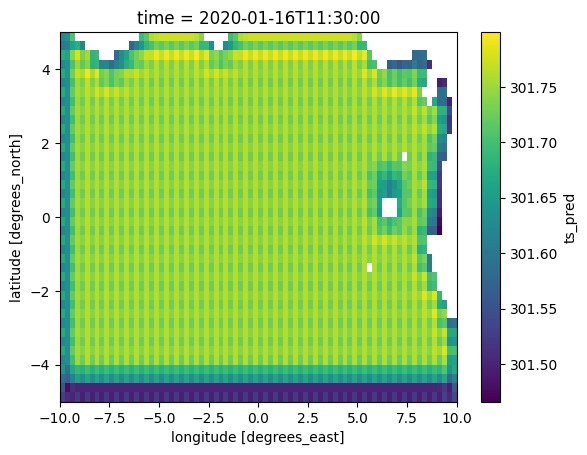

In [13]:
monthly_data["ts_pred"].isel(time=0).plot()

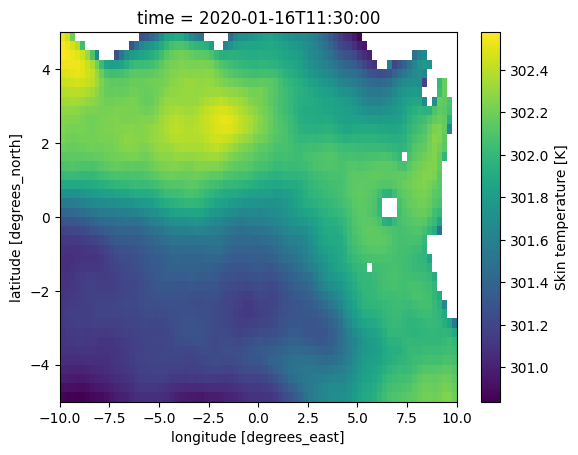

In [14]:
# original target
monthly_data["ts"].where(~lsm_mask["lsm"].values).isel(time=0).plot()

In [15]:
# Error
target = monthly_data["ts"].where(~lsm_mask["lsm"].values)
err = target - monthly_data["ts_pred"]

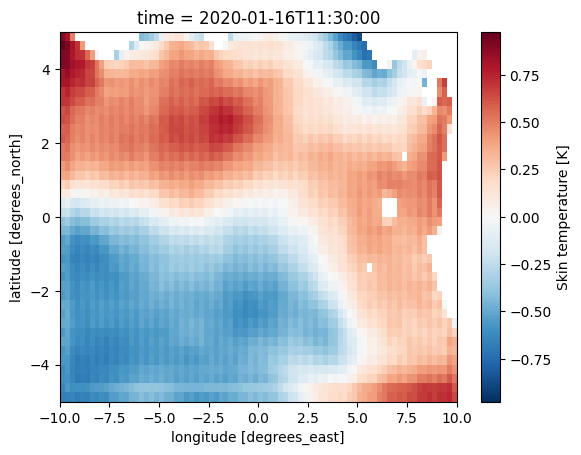

In [16]:
err.isel(time=0).plot()

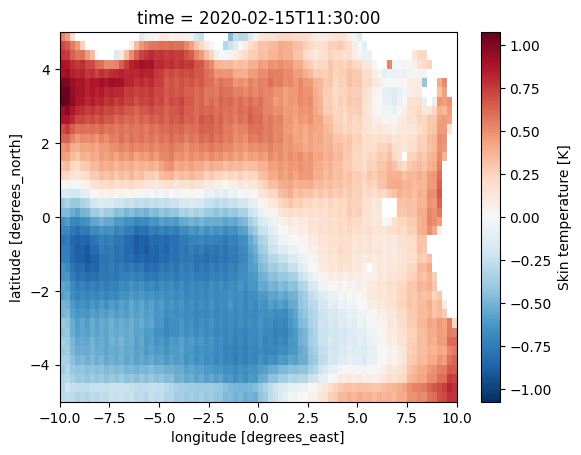

In [17]:
err.isel(time=1).plot()